# Análisis del impacto del diseño en la conversión y experiencia del usuario

Evaluar cómo los cambios de diseño afectan el flujo de conversión y validar que las nuevas fuentes mantengan o mejoren la experiencia del usuario mediante análisis estadístico.

# ANALISIS DE LLAMADAS PERDIDAS EN CallMeMaybe

## OBJETIVO

Identificar las eficacia de los operadores en la compañia asi como derterminar cuales son aquellos que son ineficaces, permiteindo entender la mejorar que requiere el equipo de operadores

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
Comparto link del PDF de la presentación y de Tableau Calud asociado al DASH:
</div>

- LINK PDF
https://drive.google.com/drive/folders/1-tmVV0ij3SA7v99MdFn4OmgnWpEwPt47?dmr=1&ec=wgc-drive-globalnav-goto
- LINK TABLAU_CLOUD https://public.tableau.com/app/profile/daniel.leonardo.robelto.bayona/viz/Duraciondellamadapordireccion/Duraciondellamadapordireccion?publish=yes

<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - El dashboard presenta una visualización clara y organizada sobre la duración de las llamadas y su clasificación entre internas y externas. La barra superior facilita identificar la distribución de la duración de llamadas, mientras que el gráfico circular muestra una proporción clara de llamadas internas y externas. Los gráficos están bien diseñados y resultan útiles para un análisis rápido. ¡Buen trabajo en estructurar la información de manera comprensible!

</div>

## Librerias  y datos a usar 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levene, ttest_ind

In [2]:
# Cargar datasets
telecom_data = pd.read_csv('/datasets/telecom_dataset_us.csv')
clients_data = pd.read_csv('/datasets/telecom_clients_us.csv')

# Identifcar duplicados
print(telecom_data.duplicated().sum())
print(clients_data.duplicated().sum())

# Revisar valores nulos y tipos de datos
print(telecom_data.isnull().sum())
print(clients_data.isnull().sum())

# Conversión de tipos de datos
telecom_data['date'] = pd.to_datetime(telecom_data['date'])
clients_data['date_start'] = pd.to_datetime(clients_data['date_start'])



# Vista preliminar
print(telecom_data.info())
print(clients_data.info())


4900
0
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64
user_id        0
tariff_plan    0
date_start     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53785 non-null  object                               
 4   operator_id          45730 non-null  float64                           

In [3]:
#print(telecom_data[(telecom_data['operator_id'] == 879898.0)])
# Dividir los grupos con base en la eficiencia
telecom_data = telecom_data[telecom_data['operator_id'] != -1]

### MANEJO DE DUPLICADOS Y NULOS

In [4]:
#Eliminacion de duplciados.
telecom_data_cleaned = telecom_data.drop_duplicates()
clients_data_cleaned = clients_data.drop_duplicates()

# Ver proporción de nulos en operator_id
null_percentage = telecom_data['operator_id'].isnull().mean() * 100
print(f"Porcentaje de valores nulos en 'operator_id': {null_percentage:.2f}%")

# Verificar relación entre operator_id nulo y otras columnas
print(telecom_data[telecom_data['operator_id'].isnull()]['internal'].value_counts())

# Imputar valores nulos con un valor genérico
telecom_data['operator_id'].fillna(-1, inplace=True)  # Usar -1 para representar "Desconocido"


# O eliminar registros con nulos
#telecom_data = telecom_data.dropna(subset=['operator_id'])

# Confirmar cambios
print(telecom_data['operator_id'].isnull().sum())



Porcentaje de valores nulos en 'operator_id': 15.16%
False    7760
True      355
Name: internal, dtype: int64
0


<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - La imputación de valores nulos con un valor genérico (-1) está bien justificada para este caso, dado que el análisis requiere conservar todos los registros. Además, la evaluación de la relación entre `operator_id` y otras columnas demuestra un pensamiento crítico. ¡Excelente!

</div>

##  Análisis Exploratorio de Datos (EDA)

### Porcentaje de llamadas perdidas por operador

In [5]:
# Filtrar llamadas perdidas y calcular el porcentaje por operador
missed_calls = telecom_data[telecom_data['is_missed_call'] == 1]
missed_percentage = missed_calls.groupby('operator_id')['calls_count'].sum() / telecom_data.groupby('operator_id')['calls_count'].sum() * 100

print(missed_percentage.sort_values(ascending=False))

operator_id
937710.0    100.0
936296.0    100.0
919418.0    100.0
924572.0    100.0
928282.0    100.0
            ...  
969600.0      NaN
971100.0      NaN
971102.0      NaN
971354.0      NaN
973286.0      NaN
Name: calls_count, Length: 1093, dtype: float64


### Tiempo promedio de espera por operador

In [6]:
# Calcular tiempo de espera promedio (total - duración real) por operador
telecom_data['wait_time'] = telecom_data['total_call_duration'] - telecom_data['call_duration']
avg_wait_time = telecom_data.groupby('operator_id')['wait_time'].mean()

print(avg_wait_time.sort_values(ascending=False))

operator_id
925922.0    5907.443038
885890.0    5727.133574
929428.0    5325.342857
885876.0    4816.241379
908640.0    3456.461538
               ...     
914626.0       0.000000
955068.0       0.000000
958458.0       0.000000
946454.0       0.000000
960674.0       0.000000
Name: wait_time, Length: 1093, dtype: float64


### Número promedio de llamadas salientes por operador

In [7]:
# Filtrar llamadas salientes y calcular promedio por operador
outgoing_calls = telecom_data[telecom_data['direction'] == 'out']
avg_outgoing_calls = outgoing_calls.groupby('operator_id')['calls_count'].mean()

print(avg_outgoing_calls.sort_values())

operator_id
954086.0      1.000000
905480.0      1.000000
937366.0      1.000000
905862.0      1.000000
952196.0      1.000000
               ...    
885876.0    300.449074
908640.0    321.134615
929428.0    351.028571
885890.0    371.568966
925922.0    435.080000
Name: calls_count, Length: 883, dtype: float64


<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - El cálculo del porcentaje de llamadas perdidas y del tiempo promedio de espera por operador está bien ejecutado y contribuye directamente al objetivo del análisis. El uso de funciones de agrupación como `groupby` es una excelente manera de organizar los datos para obtener insights clave.

</div>

## Identificar Operadores Ineficaces

In [8]:
# Clasificar operadores ineficaces
threshold_missed = missed_percentage.quantile(0.75)
threshold_wait_time = avg_wait_time.quantile(0.75)
threshold_outgoing = avg_outgoing_calls.quantile(0.25)

# Identificar ineficacia
inefficient_operators = (missed_percentage > threshold_missed) | (avg_wait_time > threshold_wait_time) | (avg_outgoing_calls < threshold_outgoing)



print(inefficient_operators[inefficient_operators == True])


operator_id
-1.0         True
 879898.0    True
 880020.0    True
 880022.0    True
 880028.0    True
             ... 
 971102.0    True
 972408.0    True
 972410.0    True
 972412.0    True
 973120.0    True
Length: 556, dtype: bool


In [9]:
#Union de lo resultaods obtenidos de los operadores ineficientes vs eficiente s la tabala telecom_data bajo el operator_id

# Asegurarse de que 'operator_id' en telecom_data esté del tipo adecuado
telecom_data['operator_id'] = telecom_data['operator_id'].astype(int)

# Asegurarse de que el índice de 'inefficient_operators' sea el mismo que 'operator_id'
# Si 'inefficient_operators' es una Serie con índices de 'operator_id' y valores booleanos, hacemos el merge
telecom_data['is_inefficient'] = telecom_data['operator_id'].map(inefficient_operators)

# Rellenar valores nulos con False (si un operador no está en 'inefficient_operators', se considera eficiente)
telecom_data['is_inefficient'] = telecom_data['is_inefficient'].fillna(False)

# Imprimir los primeros registros para verificar
print(telecom_data[['operator_id', 'is_inefficient']].head())




   operator_id  is_inefficient
0           -1            True
1       880022            True
2       880020            True
3       880020            True
4       880022            True



<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - Los umbrales basados en percentiles están bien planteados y justifican el enfoque para clasificar operadores. Además, la integración de los resultados en la tabla principal mediante `map` es una excelente manera de simplificar la visualización y el análisis posterior. ¡Buen trabajo!

</div>

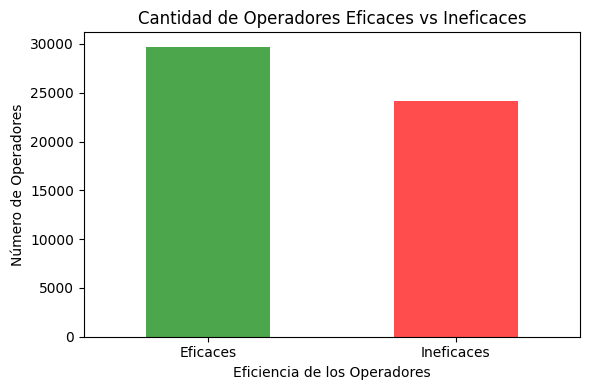

In [10]:
import matplotlib.pyplot as plt

# Contar la cantidad de operadores eficaces e ineficaces
efficiency_counts = telecom_data['is_inefficient'].value_counts()

# Crear la gráfica de barras
plt.figure(figsize=(6, 4))
efficiency_counts.plot(kind='bar', color=['green', 'red'], alpha=0.7)

# Personalizar la gráfica
plt.title('Cantidad de Operadores Eficaces vs Ineficaces')
plt.xlabel('Eficiencia de los Operadores')
plt.ylabel('Número de Operadores')
plt.xticks(ticks=[0, 1], labels=['Eficaces', 'Ineficaces'], rotation=0)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


Se evidencia una diferencia significativa entre operadores eficaces e ineficaces bajo el planteamente de los percentiles:

- Porcentaje de llamadas perdidas superior al percentil 75.
- Tiempo promedio de espera superior al percentil 75.
- Número de llamadas salientes inferior al percentil 25 (si corresponde).

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - La visualización de los operadores eficaces e ineficaces con barras es clara y bien diseñada. La elección de colores ayuda a comunicar rápidamente el contraste entre los dos grupos.

</div>


## Pruebas de Hipótesis

### Diferencias en el tiempo de espera entre operadores

Prueba de Levene (Tiempo de espera): p-value = 0.0
Prueba Mann-Whitney: statistic = 463809474.5 , p_val = 0.0
Prueba de Levene (Llamadas perdidas): p-value = 6.664424421367563e-289
Prueba Mann-Whitney: statistic = 451400675.0 , p_val = 0.0


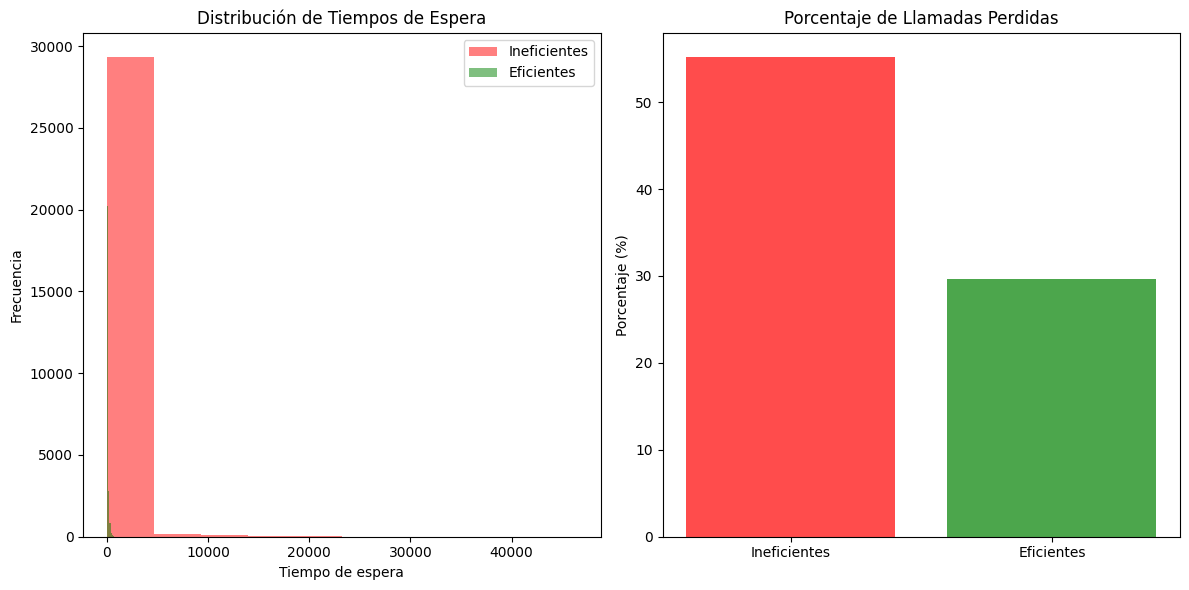

In [12]:
from scipy.stats import levene, ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt

# Filtrar grupos según la eficiencia
group_high_eff = telecom_data[telecom_data['is_inefficient'] == True]
group_low_eff = telecom_data[telecom_data['is_inefficient'] == False]

# **Hipótesis 1: Tiempo de espera promedio**
# Eliminar valores nulos en 'wait_time'
group_high_eff = group_high_eff.dropna(subset=['wait_time'])
group_low_eff = group_low_eff.dropna(subset=['wait_time'])

# Prueba de Levene para homogeneidad de varianzas
stat, p_value = levene(group_high_eff['wait_time'], group_low_eff['wait_time'])
print("Prueba de Levene (Tiempo de espera): p-value =", p_value)

if p_value > 0.05:
    # Prueba T para varianzas homogéneas
    t_stat, t_p_val = ttest_ind(group_high_eff['wait_time'], group_low_eff['wait_time'], equal_var=True)
    print("Prueba T: t_stat =", t_stat, ", p_val =", t_p_val)
else:
    # Prueba Mann-Whitney para varianzas no homogéneas
    mann_stat, mann_p_val = mannwhitneyu(group_high_eff['wait_time'], group_low_eff['wait_time'])
    print("Prueba Mann-Whitney: statistic =", mann_stat, ", p_val =", mann_p_val)

# Visualización de las distribuciones de los tiempos de espera
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(group_high_eff['wait_time'], bins=10, alpha=0.5, label='Ineficientes', color='red')
plt.hist(group_low_eff['wait_time'], bins=10, alpha=0.5, label='Eficientes', color='green')
plt.legend()
plt.title('Distribución de Tiempos de Espera')
plt.xlabel('Tiempo de espera')
plt.ylabel('Frecuencia')

# **Hipótesis 2: Porcentaje de llamadas perdidas**
# Calcular el porcentaje de llamadas perdidas para cada grupo
high_eff_missed_percentage = group_high_eff['is_missed_call'].mean() * 100
low_eff_missed_percentage = group_low_eff['is_missed_call'].mean() * 100

# Prueba de Levene para homogeneidad de varianzas
stat, p_value = levene(
    group_high_eff['is_missed_call'], 
    group_low_eff['is_missed_call']
)
print("Prueba de Levene (Llamadas perdidas): p-value =", p_value)

if p_value > 0.05:
    # Prueba T para varianzas homogéneas
    t_stat, t_p_val = ttest_ind(
        group_high_eff['is_missed_call'], 
        group_low_eff['is_missed_call'], 
        equal_var=True
    )
    print("Prueba T: t_stat =", t_stat, ", p_val =", t_p_val)
else:
    # Prueba Mann-Whitney para varianzas no homogéneas
    mann_stat, mann_p_val = mannwhitneyu(
        group_high_eff['is_missed_call'], 
        group_low_eff['is_missed_call']
    )
    print("Prueba Mann-Whitney: statistic =", mann_stat, ", p_val =", mann_p_val)

# Visualización del porcentaje de llamadas perdidas
plt.subplot(1, 2, 2)
plt.bar(['Ineficientes', 'Eficientes'], 
        [high_eff_missed_percentage, low_eff_missed_percentage], 
        color=['red', 'green'], alpha=0.7)
plt.title('Porcentaje de Llamadas Perdidas')
plt.ylabel('Porcentaje (%)')
plt.tight_layout()

plt.show()


<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - La aplicación de pruebas de hipótesis como Levene, T-test y Mann-Whitney es adecuada para este caso. La integración de estas pruebas con visualizaciones permite validar los resultados estadísticos de manera efectiva.

</div>


1. Tiempo de espera entre operadores

- La prueba de Mann-Whitney muestra que los operadores eficaces tienen tiempos de espera significativamente menores que los menos eficaces (p-value = 0.0). Esto confirma que los operadores más eficientes resuelven los problemas de los usuarios más rápidamente, lo cual es crucial para la satisfacción del cliente y la percepción de calidad del servicio.

- Sugerencias de mejora:
--  Implementar programas de formación enfocados en la eficiencia operativa y la resolución ágil de problemas.
--  Evaluar si existen flujos de trabajo ineficientes o herramientas tecnológicas que puedan estar ralentizando el desempeño de ciertos operadores.
--  Considerar la incorporación de herramientas de soporte, como chatbots o sistemas de inteligencia artificial, para reducir la carga inicial en los operadores humanos y agilizar la atención.

2. Porcentaje de llamadas perdidas

- La diferencia significativa en las llamadas perdidas entre operadores eficaces e ineficaces (p-value = 0.0) indica que los operadores menos eficaces tienen un mayor porcentaje de llamadas no atendidas o interrumpidas. Este problema puede impactar negativamente tanto la experiencia del cliente como la reputación del servicio.

- Sugerencias de mejora:
--  Mejorar la capacitación y dotar a los operadores de herramientas necesarias para manejar las llamadas de manera más efectiva.
--  Implementar métricas en tiempo real para identificar picos de demanda y redistribuir la carga de trabajo de manera equitativa.
-- Revisar si existen limitaciones técnicas o de infraestructura que afecten de manera desproporcionada a ciertos operadores.

3. Recomendaciones generales
- Si los operadores menos eficaces no logran mejorar sus métricas tras las intervenciones, la empresa debería considerar redistribuir recursos o aplicar estrategias de gestión diferenciadas.
- Implementar un sistema de retroalimentación continua para que los operadores reciban información sobre su desempeño en tiempo real. Esto permitirá identificar problemas de manera oportuna y reforzar la mejora continua.
- Establecer objetivos claros de desempeño, monitorearlos periódicamente y ofrecer incentivos para fomentar el cumplimiento de los estándares establecidos.
4. Conclusión general
- El análisis evidencia que los operadores más eficaces no solo manejan tiempos de espera de manera más eficiente, sino que también tienen menos llamadas perdidas. Estos resultados resaltan la importancia de la formación, la tecnología y la gestión de calidad para garantizar un alto estándar de desempeño en toda la organización. Implementar las mejoras sugeridas podría no solo optimizar la eficiencia operativa, sino también elevar la satisfacción del cliente y mejorar los resultados comerciales de la empresa.



<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a><br>

<b>Éxito</b> - Las conclusiones están bien estructuradas y alineadas con los hallazgos obtenidos en el análisis. Las recomendaciones son prácticas y abordan tanto aspectos operativos como estratégicos.

</div>

---

# Comentario General del Revisor

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

¡Felicidades! El análisis presenta un flujo lógico y bien estructurado. Los cálculos son relevantes y las visualizaciones refuerzan los resultados obtenidos. Aquí algunos aspectos destacados y oportunidades de mejora:

#### Puntos Positivos:
- **Preprocesamiento:** Excelente manejo de nulos y duplicados, con atención a detalles importantes como la conversión de tipos de datos.
- **Análisis exploratorio:** Métricas clave como porcentaje de llamadas perdidas y tiempo de espera están bien calculadas.
- **Estadísticas:** Uso apropiado de pruebas de hipótesis para validar diferencias entre grupos.

#### Áreas para Mejorar:
- **Definición de variables:** Algunas variables no están completamente definidas, lo que afecta la reproducibilidad del análisis.
- **Documentación:** Podrías agregar más explicaciones sobre las decisiones metodológicas, especialmente en la clasificación de operadores ineficaces.

¡Sigue trabajando con este nivel de detalle y curiosidad! 😊🚀

</div>